# Spectral siren cosmology

In this notebook we perform a hierarchical Bayesian inference to constrain both cosmology and astrophysics. We *assume* a paramewtric model in boith cases. 

We convert our previous code to numpyro

In [1]:
import numpy as np

#Numpyro and friends
import numpyro
from numpyro.infer import NUTS,MCMC
import numpyro.distributions as dist
import jax
from jax import random
from jax import jit
from jax.config import config
import jax.numpy as jnp
from jax.scipy.special import erf
import arviz as az

config.update("jax_enable_x64", True)

#PYTHON MODULES
from constants import *
import jgwcosmo
import jgwpop
import jgw_utils as jgw

#PLOTS
import matplotlib.pyplot as plt
import corner
import sys
dir_base=sys.path[0]
dir_out=dir_base+"/plots_cosmo_mass_evolution/"

#from matplotlib.ticker import ScalarFormatter
#%config InlineBackend.figure_format = 'retina'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
fontSz = 15
fontsz = 13
fontssz = 11

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

/groups/astro/ezquiaga/miniconda/envs/inference_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
We load our fiducial universe parameters

In [2]:
from fiducial_universe import *

---
Priors

In [3]:
#Priors
log10r0_min, log10r0_max = -3., 3.
h0_min, h0_max = 0.4, 1.2
Om0_min, Om0_max = 0.1, .6
alpha_min, alpha_max = 0., 25.
kappa1_min, kappa1_max = -4., 12.
kappa2_min, kappa2_max = -4., 12.
mmin_min, mmin_max = 1., 20.
mmax_min, mmax_max = 30., 100.
b_min, b_max = 0., 1.
beta_min, beta_max = 0., 10.
zp_min, zp_max = 0., 4.
gamma_min, gamma_max = -10, 10

---

# Selection effects

In [4]:
detector = 'O5'
params = 'm1z_m2z_dL'
Ndet = 35810
Ndraw =  50000
data_inj = np.genfromtxt('data_injections/injections_'+detector+'_'+params+'_Ndraws_%s_Ndet_%s.txt' % (Ndraw,Ndet))
m1z_inj_O5 = data_inj[:,0]
m2z_inj_O5 = data_inj[:,1]
dL_inj_O5 = data_inj[:,2]
p_draw_inj_O5 = data_inj[:,3]

---
# Mock data

In [5]:
n_samples = 20
n_detections = 500

Load mock data

In [6]:
m1z_mock_samples_O5 = np.load('data_mock_catalogues/m1z_'+detector+'_Ndet_%s_Nsamples_%s.npy' % (n_detections,n_samples))
m2z_mock_samples_O5 = np.load('data_mock_catalogues/m2z_'+detector+'_Ndet_%s_Nsamples_%s.npy' % (n_detections,n_samples))
dL_mock_samples_O5 = np.load('data_mock_catalogues/dL_'+detector+'_Ndet_%s_Nsamples_%s.npy' % (n_detections,n_samples))
pdraw_mock_samples_O5= np.load('data_mock_catalogues/pdraw_'+detector+'_Ndet_%s_Nsamples_%s.npy' % (n_detections,n_samples))

---
# Likelihood

We are solving the hierarchical inference of a Poissonian proccess described by the population distribution

$$\frac{dN(\lambda)}{d\theta}=\frac{p_{pop}(\theta|\lambda)}{N}$$

where $\lambda$ are the hyperparameters of the model (power-law+peak + SFR + LCDM in our case) and $\theta$ the parameters that can be observed ($m_z$ and $d_L$ in our case).

The population likelihood is given by

$$p(\lambda)=\prod_{i}^{N_{obs}}\frac{\int d\theta p(d_i|\theta_i)p_{pop}(\theta_i|\lambda)}{\int d\theta p_{det}(\theta)p_{pop}(\theta|\lambda)}
\propto\prod_{i}^{N_{obs}}\frac{\int d\theta p_{pop}(\theta_i|\lambda)p(\theta_i|d_i/\pi_{pe}(\theta)}{\int d\theta p_{det}(\theta)p_{pop}(\theta|\lambda)}
\approx \left(\frac{N_{det}}{N}\right)^{-N_{obs}}\prod_{i}^{N_{obs}}\left\langle \frac{dN/d\theta}{N \pi_{pe}}\right\rangle_{p(\theta_i|d)}$$

where we have transformed the likelihood of the data into its posterior distribution (with the proper PE prior $\pi_{pe}(\theta)$- in our case the weigths from sampling the posteriors in different variables) and we have neglected the evidence of the data $p(d_i)$ that would cancel out when computing the posterior distribution. Then, we have approximated the expression with a Monte Carlo integral over the posterior samples of the data.

Here the expected number of detections is

$$N_{det} = N \int d\theta p_{det}(\theta)p_{pop}(\theta|\lambda) \approx N \frac{1}{N_{draw}}\sum_{j}^{N_{found}}\frac{dN/d\theta(\theta_j|\lambda)}{p_{draw}(\theta_j)}$$

that can be approximated with an injection campaign to account for the detector's sensitivity.

Note that the total rate $N$ cancels in this expression so that

$$\log p(\lambda)\approx -N_{obs}\cdot\log N_{det} + \sum_{i}^{N_{obs}}\log\left\langle \frac{dN/d\theta}{ \pi_{pe}}\right\rangle_{p(\theta_i|d)}$$

This is not the case however when the selection effects are neglected.

When considering the Poisson process with rate $N$ but marginalize over the total rate $N$ assuming a $1/N$ prior, we also get to the same expression modulo an overall constant that does not affect the inference. 

--
Nice references: https://arxiv.org/pdf/1809.02063.pdf, https://arxiv.org/pdf/1904.10879.pdf

---
*A note on Jacobians*

For this particular problem we are using data in detector frame masses and luminosity distances, but we are fitting models in the source masses and redshifts. This means that 

$$\frac{dN}{dm_zdd_L}=\frac{dN}{dmdz}\left|\frac{\partial z}{\partial d_L}\right|\left|\frac{\partial m}{\partial m_z}\right|$$

where

$$\frac{\partial d_L}{\partial z}= \frac{d_L}{1+z} + (1+z)\frac{D_H}{E(z)}$$

$$\frac{\partial m_z}{\partial m}= (1 + z)$$

If we want to fit in mass ratio then we need to add another Jacobian

$$\frac{\partial (m_1,q)}{\partial (m_1,m_2)}= \frac{1}{m_1}$$

In [7]:
#def powerlaw(m,mMin,mMax,alpha):
#    norm = (1. + alpha)/(mMax**(alpha+1.) - mMin**(alpha+1.))
#    return norm * (m**alpha)

In [15]:
def log_Rz(z,r0,zp,alpha,beta):
    logc0 = jnp.log1p((1. + zp)**(-alpha-beta))
    return jnp.log(r0) + logc0  + alpha*jnp.log1p(z) - jnp.log1p(jnp.power((1.+z)/(1.+zp),(alpha+beta)))

def log_cosmo_dL(z,dL,H0,Om0):
    Ez_i = jgwcosmo.Ez_inv(z,Om0)
    D_H = (Clight/1.0e3)  / H0 #Mpc
    
    logdiff_comoving_volume = jnp.log(1.0e-9) + jnp.log(4.0*jnp.pi) + 2.0*jnp.log(dL) +jnp.log(D_H) +jnp.log(Ez_i)-2*jnp.log1p(z)
    ddLdz = dL/(1.+z) + (1. + z)*D_H * Ez_i #Mpc 
    logJacobian_dL_z = - jnp.log(jnp.abs(ddLdz)) #Jac has absolute value 
    logJacobian_t_td = - jnp.log1p(z)
    return logdiff_comoving_volume + logJacobian_t_td + logJacobian_dL_z 

def log_cosmo(z,H0,Om0):
    dL = jgwcosmo.dL_approx(z,H0,Om0)#Mpc
    return log_cosmo_dL(z,dL,H0,Om0)

def logNdet_events(m1,m2,z,p_draw,H0,Om0,r0,Tobs,zp,alpha_z,beta,mmin,mmax,alpha,sig_m1,mu_m1,f_peak,bq,Nsamples):
    #input data (N,M): N detections x M samples
    
    log_pm1 = jgwpop.logpowerlaw_peak(m1,mmin,mmax,alpha,sig_m1,mu_m1,f_peak)
    q = m2/m1
    log_pq = jgwpop.logpowerlaw(q,0.,1.,bq)
    logJacobian_m1z_m1 = - 1.0*jnp.log1p(z)
    logJacobian_m2z_m2 = - 1.0*jnp.log1p(z)
    logJacobian_m1m2_m1q =  - jnp.log(m1)
    log_pm = log_pm1 + log_pq + logJacobian_m1z_m1 + logJacobian_m2z_m2 + logJacobian_m1m2_m1q
    logcosmo = log_cosmo(z,H0,Om0)
    logRzs = log_Rz(z,r0,zp,alpha_z,beta) + jnp.log(Tobs)
    log_dN = log_pm + logcosmo + logRzs - jnp.log(p_draw)    
    
    return jnp.sum(jax.scipy.special.logsumexp(log_dN,axis=1) - jnp.log(Nsamples))

In [16]:
#Ndet with injection sesitivity
def logdiffexp(x, y):
        return x + jnp.log1p(jnp.exp(y-x))

def logNdet_O5(m1z_inj,m2z_inj,dL_inj,p_draw_inj,Ndraw,H0,Om0,r0,Tobs,zp,alpha_z,beta,mmin,mmax,alpha,sig_m1,mu_m1,f_peak,bq):
    m1_inj, m2_inj, z_inj = jgwcosmo.detector_to_source_frame_approx(m1z_inj,m2z_inj,dL_inj,H0,Om0,zmin=1e-3,zmax=100)
    
    log_pm1 = jgwpop.logpowerlaw_peak(m1_inj,mmin,mmax,alpha,sig_m1,mu_m1,f_peak)
    q_inj = m2_inj/m1_inj
    log_pq = jgwpop.logpowerlaw(q_inj,0.,1.,bq)
    m1s_norm = jnp.linspace(tmp_min,tmp_max,1000)    
    norm_m1 = jax.scipy.integrate.trapezoid(jgwpop.powerlaw_peak(m1s_norm,mmin,mmax,alpha,sig_m1,mu_m1,f_peak),m1s_norm)
    
    logJacobian_m1z_m1 = - 1.0*jnp.log1p(z_inj)
    logJacobian_m2z_m2 = - 1.0*jnp.log1p(z_inj)
    logJacobian_m1m2_m1q =  - jnp.log(m1_inj)
    log_pm = log_pm1 + log_pq - jnp.log(norm_m1) + logJacobian_m1z_m1 + logJacobian_m2z_m2 + logJacobian_m1m2_m1q
    
    logcosmo = log_cosmo_dL(z_inj,dL_inj,H0,Om0)
    logRzs = log_Rz(z_inj,r0,zp,alpha_z,beta) + jnp.log(Tobs)
    log_dN = log_pm  + logcosmo + logRzs 
    
    #Expected number of detections
    log_N = jax.scipy.special.logsumexp(log_dN - jnp.log(p_draw_inj)) - jnp.log(Ndraw)
    
    #Effective number of samples
    log_N2 = jax.scipy.special.logsumexp(2.0*log_dN - 2.0*jnp.log(p_draw_inj)) - 2.0*jnp.log(Ndraw)
    log_sigma2 = logdiffexp(log_N2, 2.0*log_N - jnp.log(Ndraw))
    Neff = jnp.exp(2.0*log_N - log_sigma2)
    
    return log_N, Neff

In [17]:
@jit
def log_lik(h0,Om0,mmin,mmax,alpha,mu_m1,sig_m1,f_peak,bq,alpha_z,zp,beta):
    #Fixed rate
    r0 = 1.0 # 10.**log10r0
    Tobs = 1.
    #redefinition
    H0 = h0*100
    
    Nobs, Nsamples = jnp.shape(m1z_mock_samples_O5)
    
    D_H = (Clight/1.0e3)  / H0 #Mpc
    m1_mock, m2_mock, z_mock = jgwcosmo.detector_to_source_frame_approx(m1z_mock_samples_O5,m2z_mock_samples_O5,dL_mock_samples_O5,H0,Om0,zmin=1e-3,zmax=100)
    
    #Log_lik Events
    p_draw_mock = pdraw_mock_samples_O5
    loglik_E = logNdet_events(m1_mock,m2_mock,z_mock,p_draw_mock,H0,Om0,r0,Tobs,zp,alpha_z,beta,mmin,mmax,alpha,sig_m1,mu_m1,f_peak,bq,Nsamples)

    #Total rate normalization only needed when selection effects are neglected because then N does not cancel out (see notes above)
    #zs_norm = jnp.linspace(0.01,10,1000) 
    #dn_detec = jgwpop.rate_z(zs_norm,zp,alpha_z,beta)*jgwcosmo.diff_comoving_volume_approx(zs_norm,H0,Om0)/(1.+zs_norm)   
    #norm_z = jax.scipy.integrate.trapezoid(dn_detec,zs_norm)
    #loglik_E -= Nobs*jnp.log(norm_z)
    
    m1s_norm = jnp.linspace(tmp_min,tmp_max,1000)    
    norm_m1 = jax.scipy.integrate.trapezoid(jgwpop.powerlaw_peak(m1s_norm,mmin,mmax,alpha,sig_m1,mu_m1,f_peak),m1s_norm)
    loglik_E -= Nobs*jnp.log(norm_m1)
        
    #Selection effects
    log_Ndet, Neff = logNdet_O5(m1z_inj_O5,m2z_inj_O5,dL_inj_O5,p_draw_inj_O5,Ndraw,H0,Om0,r0,Tobs,zp,alpha_z,beta,mmin,mmax,alpha,sig_m1,mu_m1,f_peak,bq)
    loglik_N = -Nobs*log_Ndet
        
    return loglik_N + loglik_E, Neff

In [18]:
def log_probability():
    
    #Priors
    h0 = numpyro.sample("h0",dist.Uniform(h0_min,h0_max))
    Om0 = Om0_fid#numpyro.sample("Om0",dist.Uniform(Om0_min,Om0_max))
    mmin = numpyro.sample("mmin",dist.Uniform(mmin_min,mmin_max))
    mmax = numpyro.sample("mmax",dist.Uniform(mmax_min,mmax_max))
    alpha = numpyro.sample("alpha",dist.Normal(0,5))
    mu_m1 = numpyro.sample("mu_m1",dist.Uniform(20,60))
    sig_m1 = sig_m1_fid#numpyro.sample("sig_m1",dist.Uniform(1,10))
    f_peak = f_peak_fid#numpyro.sample("f_peak",dist.Uniform(0,1))
    #Fixed
    bq = bq_fid
    alpha_z = alpha_z_fid#numpyro.sample("alpha_z",dist.Uniform(0,2))#numpyro.deterministic('alpha_z',alpha_z_fid)#numpyro.sample("alpha_z",dist.Normal(0,5))
    zp = zp_fid #numpyro.deterministic('zp',zp_fid)
    beta = beta_fid #numpyro.deterministic('beta',beta_fid)
    bq = bq_fid #numpyro.sample("bq",dist.Normal(0,5)) #when fitting m_2
    
    loglik, Neff = log_lik(h0,Om0,mmin,mmax,alpha,mu_m1,sig_m1,f_peak,bq,alpha_z,zp,beta)
    
    conv = numpyro.deterministic('conv', Neff/4/n_detections)

    #Likelihood
    numpyro.factor("logp",loglik)

In [19]:
nChains = 1
numpyro.set_host_device_count(nChains)

rng_key = random.PRNGKey(2)
rng_key,rng_key_ = random.split(rng_key)

In [20]:
# Set up NUTS sampler over our likelihood
kernel = NUTS(log_probability)
mcmc = MCMC(kernel,num_warmup=100,num_samples=100,num_chains=nChains,chain_method='parallel')##num_warmup=300,num_samples=3000
#mcmc = MCMC(kernel,num_warmup=500,num_samples=3000,num_chains=nChains,chain_method='parallel')##num_warmup=300,num_samples=3000

sample: 100%|██████████| 200/200 [01:09<00:00,  2.87it/s, 7 steps of size 3.00e-01. acc. prob=0.96] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -2.73      0.11     -2.73     -2.91     -2.59     39.19      1.02
        h0      0.92      0.09      0.93      0.77      1.07     47.11      1.03
      mmax     73.44      2.23     73.35     70.42     77.11     56.45      0.99
      mmin      9.48      0.23      9.48      9.16      9.90     54.79      1.04
     mu_m1     26.89      1.07     26.82     25.39     28.81     56.81      1.01

Number of divergences: 0
Fiducial values:
H0= 67.66 , Om0= 0.30966
alpha= -2.7 , bq= 0.0 , f_peak= 0.05 , mmax= 78.0 , mmin= 10.0 , mu_m1= 30.0 , sig_m1= 7.0
alpha_z= 1.0 , zp= 2.4 , beta= 3.4


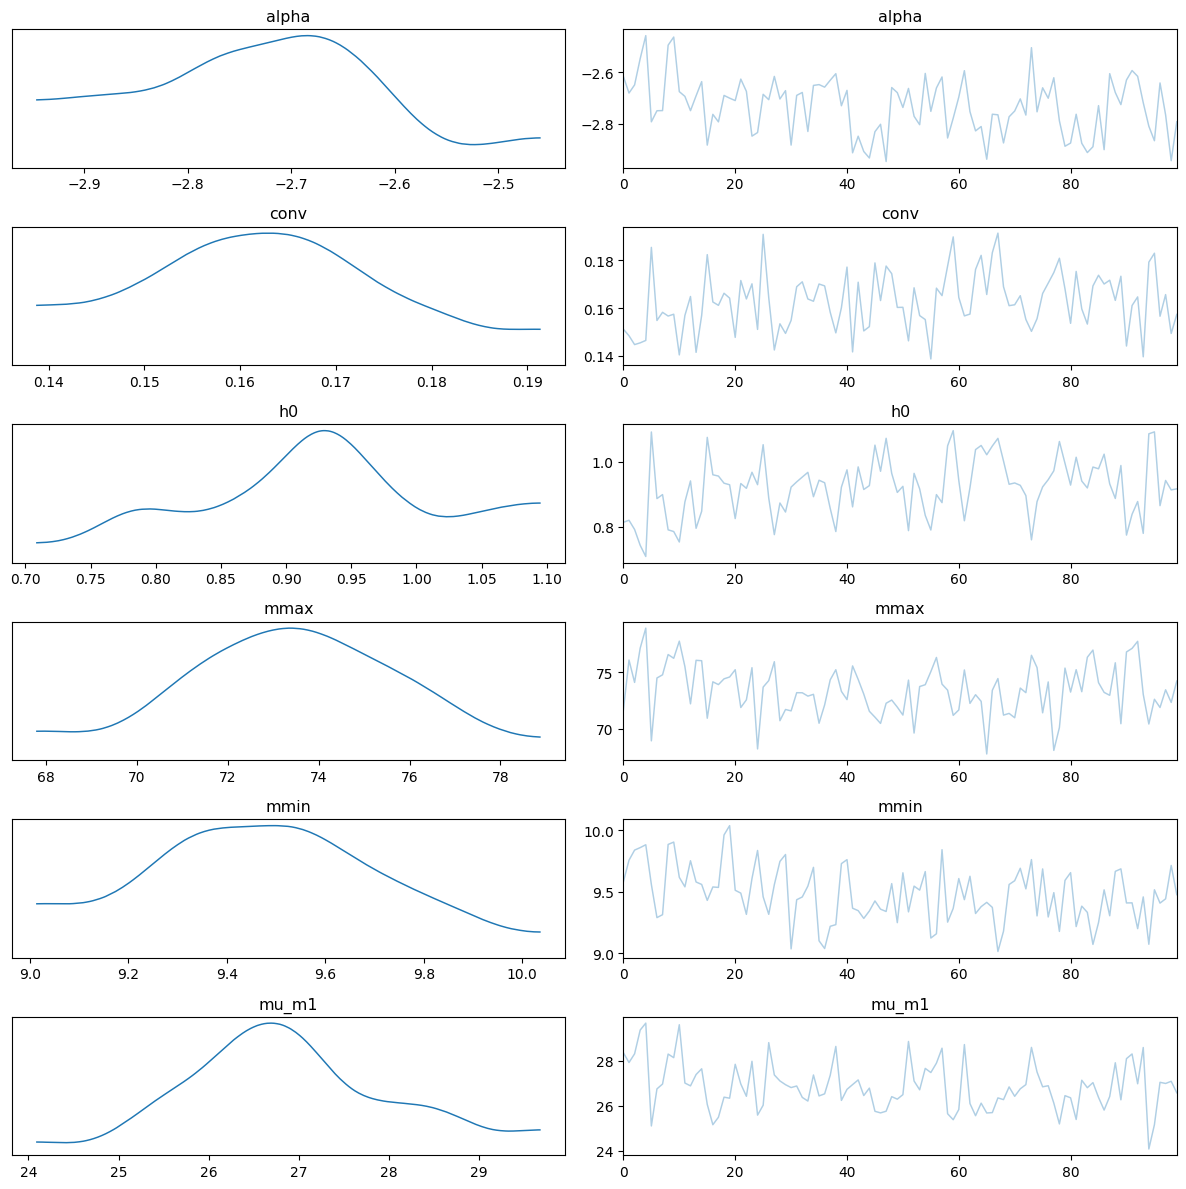

In [21]:
mcmc.run(rng_key_)#, init_params=jnp.array([H0_fid/100,Om0_fid,mmin_fid, mmax_fid,alpha_fid,mu_m1_fid,sig_m1_fid,f_peak_fid])
mcmc.print_summary()
samples = mcmc.get_samples()

print('Fiducial values:')
print('H0=',H0_fid,', Om0=',Om0_fid)
print('alpha=',alpha_fid,', bq=',bq_fid,', f_peak=',f_peak_fid,', mmax=',mmax_fid,', mmin=',mmin_fid,', mu_m1=',mu_m1_fid,', sig_m1=',sig_m1_fid)
print('alpha_z=',alpha_z_fid,', zp=',zp_fid,', beta=',beta_fid)
az.plot_trace(mcmc, compact=True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_135465/1878313325.py:21: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  pm_true /= jnp.trapz(pm_true,massess)


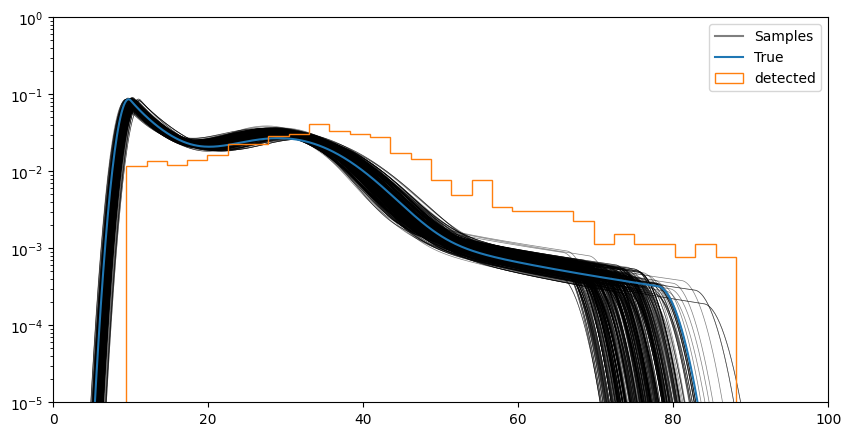

In [16]:
fig,ax = plt.subplots(figsize=(10,5))

m1_grid = np.linspace(2,150,1000)

random_inds = np.random.choice(np.arange(samples['mmax'].size),size=500)
for i in random_inds:
    
    p_m1 = jgwpop.powerlaw_peak(m1_grid,
                            samples['mmin'][i],
                           samples['mmax'][i],
                           samples['alpha'][i],
                            samples['sig_m1'][i],
                            samples['mu_m1'][i],
                            samples['f_peak'][i])
    p_m1 /= np.trapz(p_m1,m1_grid)
    
    ax.plot(m1_grid,p_m1,color='black',lw=0.5,alpha=0.5)

massess = np.linspace(2,150,1000)
pm_true = jgwpop.powerlaw_peak(massess,mmin_fid,mmax_fid,alpha_fid,sig_m1_fid,mu_m1_fid,f_peak_fid)
pm_true /= jnp.trapz(pm_true,massess)

ax.plot([],'k',alpha=0.5,label='Samples')
ax.semilogy(massess,pm_true,label='True')    

D_H = (Clight/1.0e3)  / H0_fid #Mpc
m1z_mock_O5 = np.median(m1z_mock_samples_O5,axis=1)
m2z_mock_O5 = np.median(m2z_mock_samples_O5,axis=1)
dL_mock_O5 = np.median(dL_mock_samples_O5,axis=1)
m1s_mock, m2s_mock, zs_mock = jgwcosmo.detector_to_source_frame_approx_dLdH(m1z_mock_O5,m2z_mock_O5,dL_mock_O5/D_H,Om0_fid,zmin=1e-3,zmax=100)

ax.hist(m1s_mock,bins=30,density=True, histtype='step',label='detected')

ax.set_yscale('log')
ax.set_ylim(1e-5,1)
ax.set_xlim(0,100)
plt.legend()
plt.show()

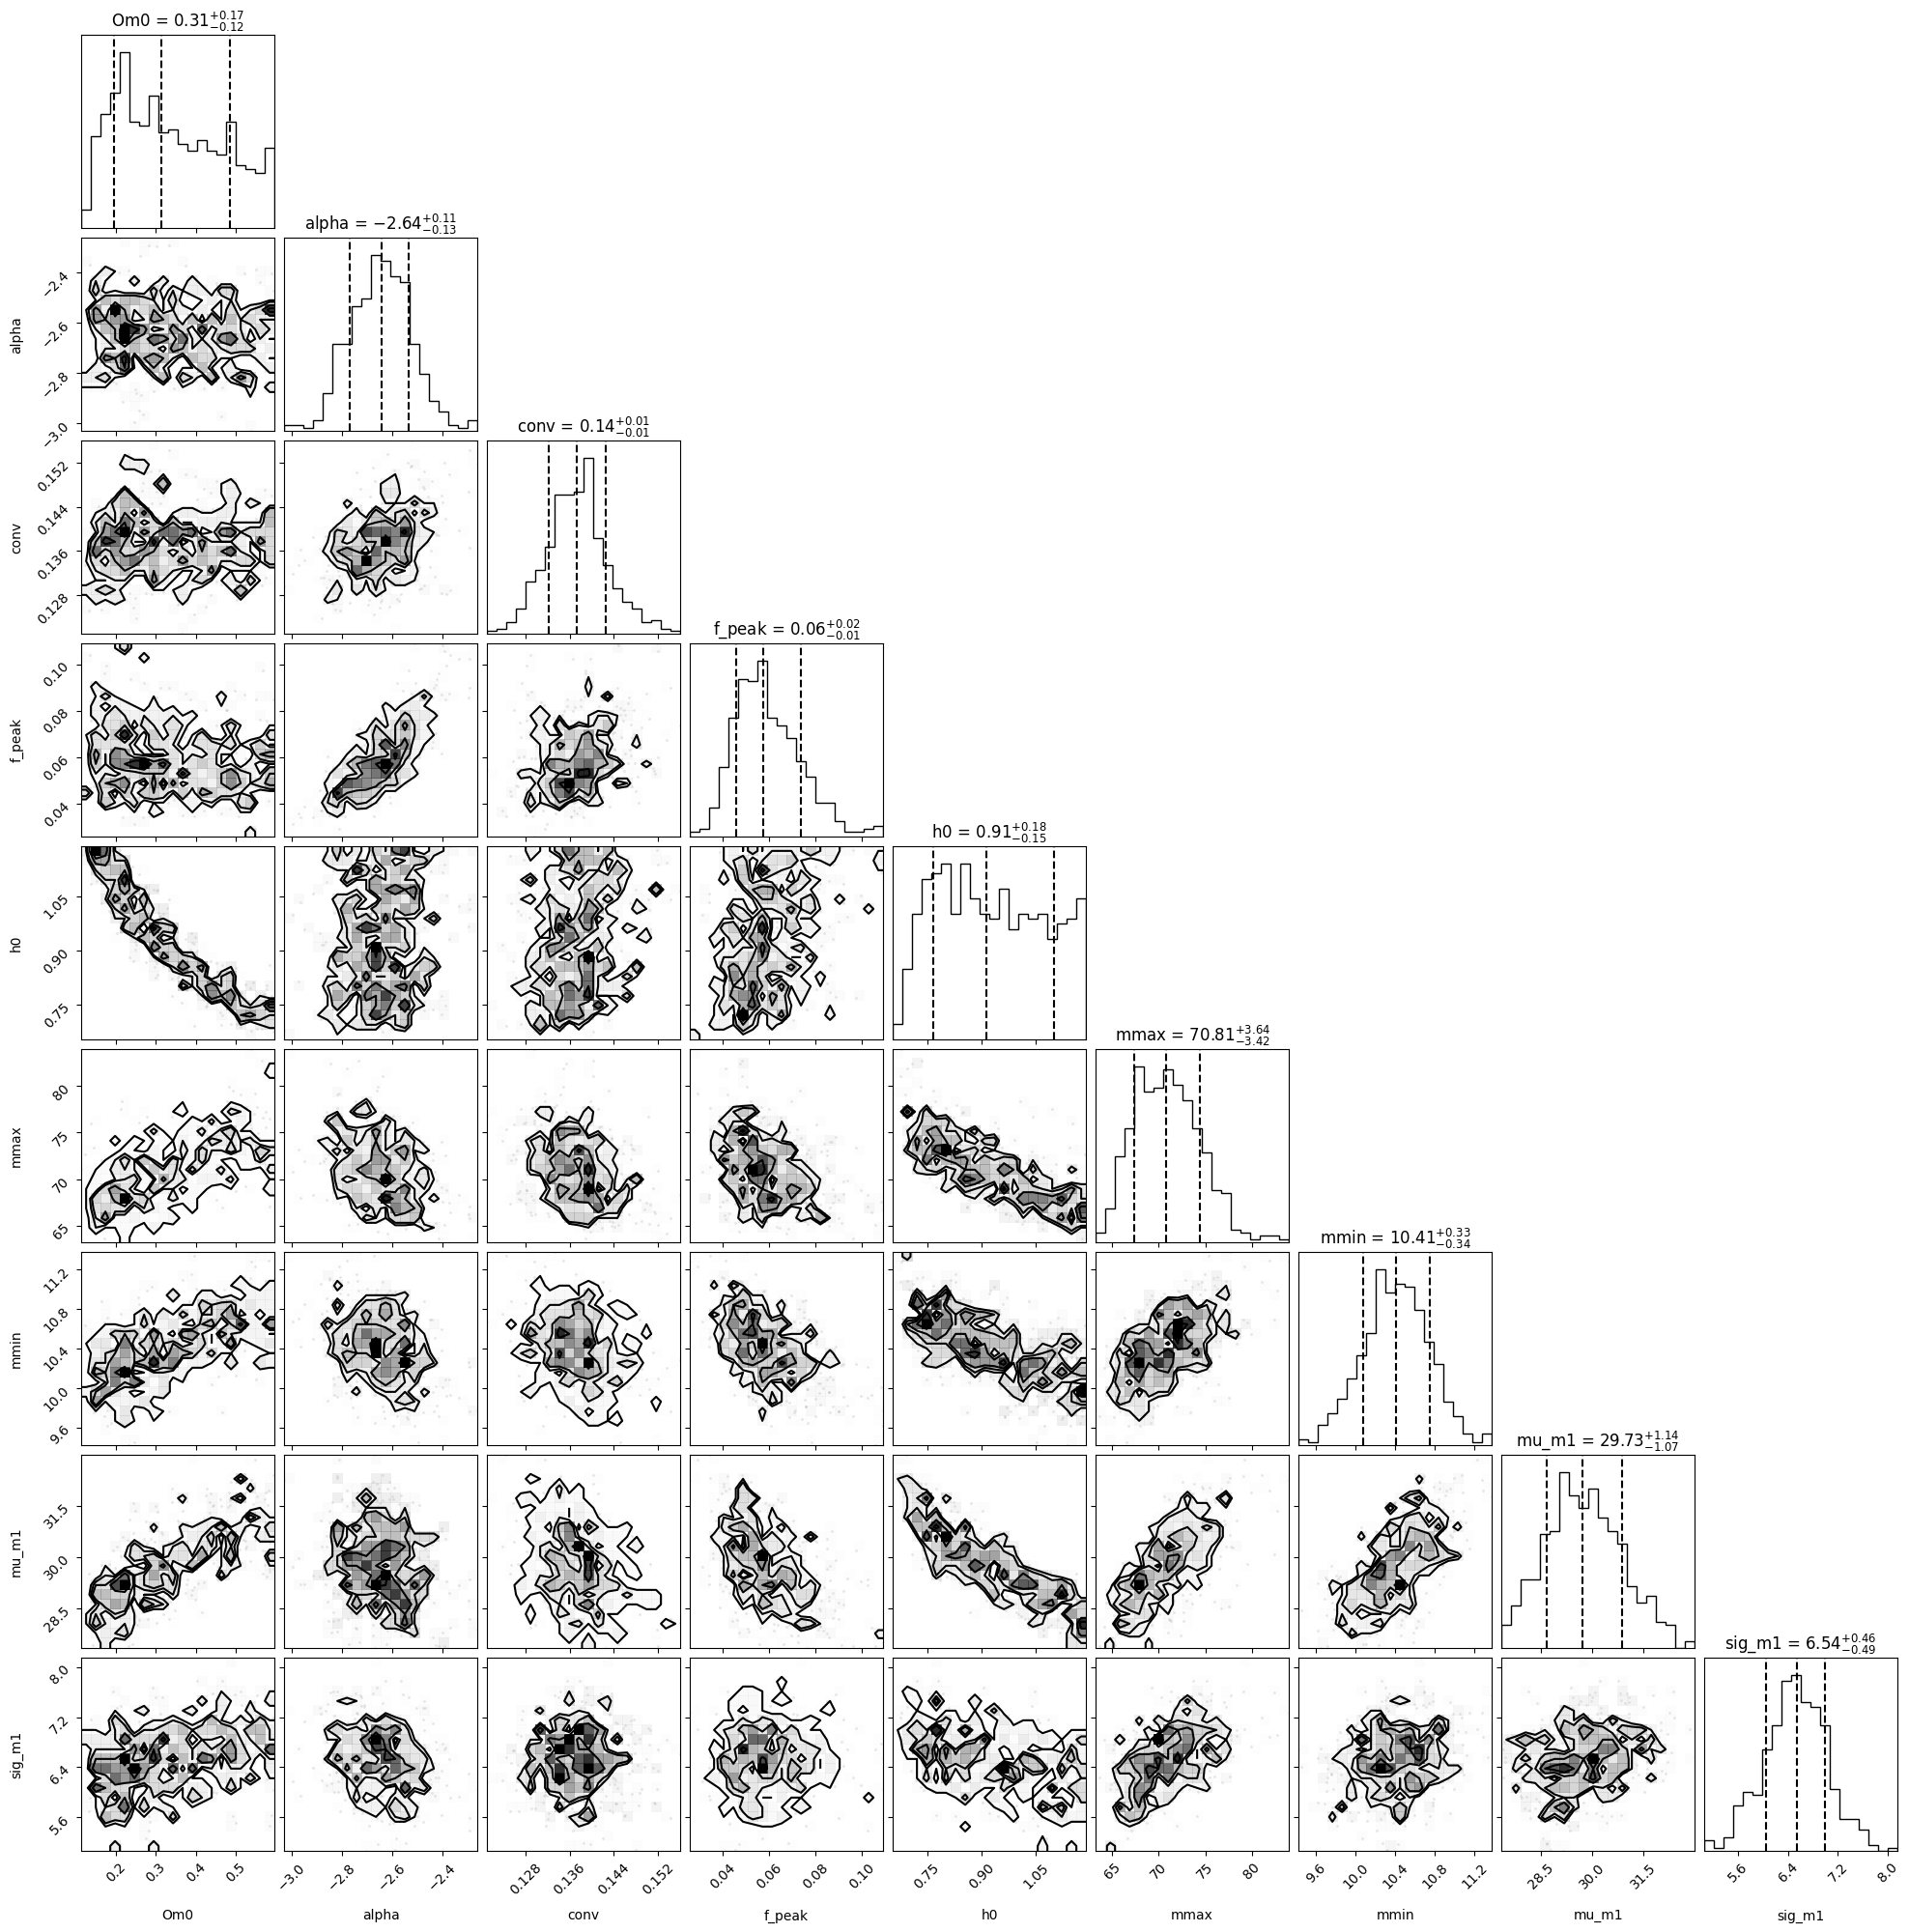

In [17]:
fig = corner.corner(
    samples,quantiles=[0.16, 0.5, 0.84],#, labels=labels
                       show_titles=True,fontsize=fontsz#, truths=[H0_fid/100,alpha_ml, zp_ml]
);
plt.show()